In [94]:
import time, os, re, json, requests
import numpy as np
import pandas as pd
import networkx as nx
from statistics import mean 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline 


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [347]:
tr_list = ['c7a3673f869fc9c5c5e8f032af97546efed0435762e4ef728f99b6725c027f9b',
           '34ed08b17fff9cbe51ce33c62c6c1bb115f82aeec60997bfb216126bf747b5c8']

addr_list = ['1HRPPH6gVPhL4tTbAM5CCcDFt2bXpR5vNm',
             '3BPMdL5WVNYdBWVzfqRNkAMHiMkegporXn',
             '3HpWfb94RXgbj59PnJijayj9t2ebFkfCQn',
             '3GdH7YrcFgQv4EANKDw66aZwruYCQ21LpL',
             '1FQFFxz5TPJsRwkqHJa4ecd9gjQS2hYcbt',
             '1KqtK7K46kiFCV2XzAt43AYxNVwPuEccW6']

# 1JqmxxswaEpvEcLJJLe8BTvmSHKYzY7LBn
# 3AuShAzkBaAvL6Xc4y61Jfnf7AM7s3Wpmb
# 3HjJQWMhhJjAkPiZKywDYyhXDdWkSFLW9F
# 3MycntSknbumLyRX56X8xbwxJ1zqHHq1VD

# READ

In [4]:
data = {}

In [5]:
%%time 
path = './add_jsons'
for file in os.listdir(path):
    try:
        with open(path + '/{}'.format(file), 'r') as f:
            results = json.load(f)
        txid = results['txid']
        data[txid] = results
    except:
        print(file)

.DS_Store
CPU times: user 19.1 s, sys: 11.3 s, total: 30.5 s
Wall time: 1min 23s


In [6]:
len(data)

100267

In [7]:
df = []
trs = list(data.keys())
for tr in trs:
    df.append(data[tr])
    
cols = list(data[trs[0]].keys())
data = pd.DataFrame(df, columns=cols)

In [8]:
data['is_coinbase'] = data['is_coinbase'].map({False: 0, True: 1}).astype(int)
data['is_double_spend'] = data['is_double_spend'].map({False: 0, True: 1}).astype(int)
data['is_sw_tx'] = data['is_sw_tx'].map({False: 0, True: 1}).astype(int)

In [9]:
#add suspicious labels
data['is_suspicious'] = data['txid'].apply(lambda x: 1 if x in tr_list else 0)

In [10]:
data.head()

,txid,confirmations,time,is_coinbase,is_double_spend,is_sw_tx,weight,vsize,inputs_count,outputs_count,...,min_next_val,avg_next_val,list_of_output,diff_max_prev_time,diff_min_prev_time,diff_avg_prev_time,diff_max_next_time,diff_min_next_time,diff_avg_next_time,is_suspicious
0,c2f17ddaedd0b4d81baa394b39d5ebdd36ceb68ca10e18...,6706,1555684573,0,0,0,900,225,1,2,...,25280000.0,29542595.0,[{'next_address': '1AQvhJzes9Qr6fRuHo2ju3VNWZq...,9719.0,9719.0,9719.0,273417.0,8434.0,140925.0,0
1,6349c6a574e02c58a55fdada235e4f1c4e9577529898b8...,18517,1548689183,0,0,1,4166,1042,1,29,...,1115337.0,322753424.0,[{'next_address': '3FSVMXC3LXtbBPAA5N9dkSwdv63...,0.0,0.0,0.0,1149882.0,0.0,138393.0,0
2,221ff5c34cc8b9939765c739acfd43b4e0d75a6cdd5a4c...,4965,1556325356,0,0,0,1116,279,1,2,...,80624740.0,80624740.0,[{'next_address': '34uha9QRWvcipP1Q3fKuzTiHfsm...,489563.0,489563.0,489563.0,54552.0,54552.0,54552.0,0
3,f1ff549d02dd9dbd3fce08932a1a4aab604f878fc736cc...,26246,1544109462,0,0,1,35952,8988,97,5,...,13416348.0,81843511.0,[{'next_address': '3MFhGBmkcoarqkLG5qUr27RKSA5...,2209.0,5092.0,2499.0,607946.0,4212.0,143905.0,0
4,d236c720afea8852dc06959b5a4bf2bcc34db94b3850b2...,20622,1547303088,0,0,1,36513,9129,100,1,...,137329701.0,137329701.0,[{'next_address': '3BdjCSD7VyN4qMWL6g2qC3FmNEs...,696.0,773916.0,83442.0,248432.0,248432.0,248432.0,0


## Feature Matrix

Хотим получить матрицу, где по строкам будут транзакции относительно адресов:
1. если у транзакции было n входящих (исходящих) адресов, то данная транзакция преобразовывается в n строк
2. если у транзакции было n входящих и m исходящих адресов, то данная транзакция преобразовывается в n+m строк

#### Features

1. 'txid' - id текущей транзакции
2. 'confirmations' - число подтверждений 
3. 'time' - время совершения данной транзакции 
4. 'is_coinbase' - флаг 
5. 'is_double_spend' - флаг
6. 'is_sw_tx' - флаг 
7. 'weight' - вес
8. 'vsize' - вес
9. 'inputs_count' - число входящих адресов
10. 'outputs_count'- число исходящих адресов
11. 'inputs_value' - общая сумма текущей транзакции (отличается от curr_value, если более 1 входа)
12. 'outputs_value' - общая сумма исходящей транзакции (отличается от curr_value-fee, если более 1 выхода) 
13. 'max_prev_val' - максимальная сумма среди предыдущих транзакций (отличается от tot_prev_tx_value, если более 1 входа) 
14. 'min_prev_val' - минимальная сумма среди предыдущих транзакций (отличается от tot_prev_tx_value, если более 1 входа)   
15. 'avg_prev_val' - средняя сумма предыдущих транзакций (отличается от tot_prev_tx_value, если более 1 входа)          
16. 'max_next_val' - максимальная сумма среди следующих транзакций (отличается от tot_next_tx_value, если более 1 входа)
17. 'min_next_val' - минимальная сумма среди следующих транзакций (отличается от tot_next_tx_value, если более 1 входа)
18. 'avg_next_val' - средняя сумма следующих транзакций (отличается от tot_next_tx_value, если более 1 входа)          
19. 'diff_max_prev_time' - максимальная разница во времени текущей транзакции относительно всех предыдущих (отличается от diff_prev_time, если более 1 входа)
20. 'diff_min_prev_time' - минимальна разница во времени текущей транзакции относительно всех предыдущих (отличается от diff_prev_time, если более 1 входа)
21. 'diff_avg_prev_time' - средняя разница во времени текущей транзакции относительно всех предыдущих (отличается от diff_prev_time, если более 1 входа)
22. 'diff_max_next_time' - максимальная разница во времени текущей транзакции относительно всех следующих (отличается от diff_next_time, если более 1 входа)
23. 'diff_min_next_time' - минимальная разница во времени текущей транзакции относительно всех следующих (отличается от diff_next_time, если более 1 входа)
24. 'diff_avg_next_time' - средняя разница во времени текущей транзакции относительно всех следующих (отличается от diff_next_time, если более 1 входа)
25. 'is_suspicious' - флаг, является ли транзакция подозрительной (1, если транзакция есть в первоначальном списке tr_list)
26. 'transaction_type' - тип пранзакции (1,2,3,4)
27. 'input_add' - входящий адрес
28. 'output_add' - исходящий адрес
29. 'curr_value' - сумма транзакции для данного входящего/исходящего адреса (в зависимости от transaction_type)
30. 'tot_prev_tx_value' - размер предыдущей транзакции для данного input_add (если transaction_type=4, то берется avg_prev_val) <span style="color:red"> (лучше брать avg, min или max ??????)</span>
31. 'tot_next_tx_value' - размер следующей транзакции для данного input_add (если transaction_type=4, то берется avg_next_val) <span style="color:red"> (лучше брать avg, min или max ??????)</span>
32. 'diff_prev_time' - задержка текущей транзакции относительно предыдущей (если transaction_type=4, то берется diff_avg_prev_time)  <span style="color:red"> (лучше брать avg, min или max ??????)</span>
33. diff_next_time - задержка следующей транзакции относительно текущей (если transaction_type=4, то берется diff_avg_next_time)  <span style="color:red"> (лучше брать avg, min или max ??????)</span>

In [11]:
data.head()

,txid,confirmations,time,is_coinbase,is_double_spend,is_sw_tx,weight,vsize,inputs_count,outputs_count,...,min_next_val,avg_next_val,list_of_output,diff_max_prev_time,diff_min_prev_time,diff_avg_prev_time,diff_max_next_time,diff_min_next_time,diff_avg_next_time,is_suspicious
0,c2f17ddaedd0b4d81baa394b39d5ebdd36ceb68ca10e18...,6706,1555684573,0,0,0,900,225,1,2,...,25280000.0,29542595.0,[{'next_address': '1AQvhJzes9Qr6fRuHo2ju3VNWZq...,9719.0,9719.0,9719.0,273417.0,8434.0,140925.0,0
1,6349c6a574e02c58a55fdada235e4f1c4e9577529898b8...,18517,1548689183,0,0,1,4166,1042,1,29,...,1115337.0,322753424.0,[{'next_address': '3FSVMXC3LXtbBPAA5N9dkSwdv63...,0.0,0.0,0.0,1149882.0,0.0,138393.0,0
2,221ff5c34cc8b9939765c739acfd43b4e0d75a6cdd5a4c...,4965,1556325356,0,0,0,1116,279,1,2,...,80624740.0,80624740.0,[{'next_address': '34uha9QRWvcipP1Q3fKuzTiHfsm...,489563.0,489563.0,489563.0,54552.0,54552.0,54552.0,0
3,f1ff549d02dd9dbd3fce08932a1a4aab604f878fc736cc...,26246,1544109462,0,0,1,35952,8988,97,5,...,13416348.0,81843511.0,[{'next_address': '3MFhGBmkcoarqkLG5qUr27RKSA5...,2209.0,5092.0,2499.0,607946.0,4212.0,143905.0,0
4,d236c720afea8852dc06959b5a4bf2bcc34db94b3850b2...,20622,1547303088,0,0,1,36513,9129,100,1,...,137329701.0,137329701.0,[{'next_address': '3BdjCSD7VyN4qMWL6g2qC3FmNEs...,696.0,773916.0,83442.0,248432.0,248432.0,248432.0,0


Будем рассматривать 4 вида транзакций (и по-разному формировать для них матрицу фичей)

|transaction_type|num_of_inputs  |num_of_outputs|
|----|---------------|--------------|
| 1  | 1             | 1            |
| 2  | several       | 1            |
| 3  | 1             | several      |
| 4  | several       | several      |

In [12]:
def transaction_type(row):
    if   row[0]==1 and row[1]==1: return 1
    elif row[0] >1 and row[1]==1: return 2
    elif row[0]==1 and row[1] >1: return 3
    elif row[0] >1 and row[1] >1: return 4
    else: return 0

In [13]:
data['transaction_type'] = [transaction_type(x) for x in data[['inputs_count', 'outputs_count']].values]

In [14]:
#кол-во транзакций каждого типа в датасете
data.groupby('transaction_type').count()[['txid']].T

transaction_type,1,2,3,4
txid,1096,13600,44639,40932


In [15]:
cols = ['txid',
 'confirmations',
 'time',
 'is_coinbase',
 'is_double_spend',
 'is_sw_tx',
 'weight',
 'vsize',
 'inputs_count',
 'outputs_count',
 'inputs_value',
 'outputs_value',
 'max_prev_val',
 'min_prev_val',
 'avg_prev_val',
 'max_next_val',
 'min_next_val',
 'avg_next_val',
 'diff_max_prev_time',
 'diff_min_prev_time',
 'diff_avg_prev_time',
 'diff_max_next_time',
 'diff_min_next_time',
 'diff_avg_next_time',
 'is_suspicious',
 'transaction_type',
 'input_add',
 'output_add',
 'curr_value',
 'tot_prev_tx_value',
 'tot_next_tx_value',
 'diff_prev_time',
 'diff_next_time']

## transaction_type = 1

In [17]:
data_1 = data[data['transaction_type'] == 1]

In [18]:
#входящий и исходящий адреса
data_1['input_add'] = data_1['list_of_input'].apply(lambda x: x[0]['prev_address'])
data_1['output_add'] = data_1['list_of_output'].apply(lambda x: x[0]['next_address'] if len(x) else None)

In [19]:
#сумма текущей транзакции
#считаем current value по input'у
data_1['curr_value'] = data_1['list_of_input'].apply(lambda x: x[0]['curr_value'])

In [20]:
#общая сумма предыдущей и следующей транзакций (не сколько на адрес пришло, а именно всей транзакции целиком)
data_1['tot_prev_tx_value'] = data_1['list_of_input'].apply(lambda x: x[0]['total_prev_val'])
data_1['tot_next_tx_value'] = data_1['list_of_output'].apply(lambda x: x[0]['total_next_val'] if len(x) else None)

In [21]:
#дата совершения предыдущей и следующей транзакций 
data_1['prev_time'] = data_1['list_of_input'].apply(lambda x: x[0]['prev_time'])
data_1['next_time'] = data_1['list_of_output'].apply(lambda x: x[0]['next_time'] if len(x) else None)

In [22]:
#задержка относительно предыдущей и следующей транзакций 
data_1['diff_prev_time'] = data_1['time'] - data_1['prev_time']
data_1['diff_next_time'] = data_1['next_time'] - data_1['time']

In [23]:
data_1_upd = data_1[cols]

In [24]:
len(data_1_upd.columns)

33

## transaction_type = 2

In [25]:
data_2 = data[data['transaction_type'] == 2].reset_index(drop=True)

In [26]:
%%time

#convert input adds
tmp_inp = data_2.list_of_input\
          .apply(pd.Series).merge(data_2[['txid','list_of_input']], left_index = True, right_index = True)\
          .drop(['list_of_input'], axis = 1)\
          .melt(id_vars = ['txid'], value_name = 'input_add')\
          .drop('variable', axis = 1).dropna().reset_index(drop=True)

CPU times: user 9.02 s, sys: 538 ms, total: 9.55 s
Wall time: 9.86 s


In [27]:
%%time

tmp_inp = tmp_inp['input_add'].apply(pd.Series)\
          .merge(tmp_inp[['txid','input_add']], left_index = True, right_index = True)\
          .drop(['input_add'], axis = 1)\
          .rename({'prev_address': 'input_add','total_prev_val': 'tot_prev_tx_value'}, axis=1)

CPU times: user 7min 3s, sys: 1min 25s, total: 8min 28s
Wall time: 8min 56s


In [28]:
%%time

#вытаскиваем исходящий адрес
data_2['output_add'] = data_2['list_of_output'].apply(lambda x: x[0]['next_address'] if len(x) else None)
data_2['tot_next_tx_value'] = data_2['list_of_output'].apply(lambda x: x[0]['total_next_val'] if len(x) else None)

CPU times: user 111 ms, sys: 604 ms, total: 715 ms
Wall time: 1.69 s


In [29]:
#дата совершения следующей транзакции
data_2['next_time'] = data_2['list_of_output'].apply(lambda x: x[0]['next_time'] if len(x) else None)

In [30]:
data_2 = data_2.set_index('txid')
tmp_inp = tmp_inp.set_index('txid')

In [31]:
cols_to_take = ['output_add', 'tot_next_tx_value', 'next_time', 'confirmations',
                'time', 'is_coinbase', 'is_double_spend', 'is_sw_tx', 'weight', 'vsize',
                'inputs_count', 'outputs_count', 'inputs_value', 'outputs_value', 'max_prev_val',
                'min_prev_val', 'avg_prev_val', 'max_next_val', 'min_next_val', 'avg_next_val',
                'diff_max_prev_time', 'diff_min_prev_time', 'diff_avg_prev_time', 'diff_max_next_time',
                'diff_min_next_time', 'diff_avg_next_time', 'is_suspicious', 'transaction_type']

data_2_upd = tmp_inp.join(data_2[cols_to_take], how='left').reset_index()

In [32]:
#задержка относительно предыдущей и следующей транзакций 
data_2_upd['diff_prev_time'] = data_2_upd['time'] - data_2_upd['prev_time']
data_2_upd['diff_next_time'] = data_2_upd['next_time'] - data_2_upd['time']

In [33]:
data_2_upd = data_2_upd[cols]

In [34]:
len(data_2_upd.columns)

33

## transaction_type = 3

In [35]:
data_3 = data[data['transaction_type'] == 3].reset_index(drop=True)

In [36]:
%%time

#convert input adds
tmp_outp = data_3.list_of_output\
          .apply(pd.Series).merge(data_3[['txid','list_of_output']], left_index = True, right_index = True)\
          .drop(['list_of_output'], axis = 1)\
          .melt(id_vars = ['txid'], value_name = 'output_add')\
          .drop('variable', axis = 1).dropna().reset_index(drop=True)

CPU times: user 20.3 s, sys: 3.27 s, total: 23.6 s
Wall time: 25.7 s


In [37]:
%%time

tmp_outp = tmp_outp['output_add'].apply(pd.Series)\
          .merge(tmp_outp[['txid','output_add']], left_index = True, right_index = True)\
          .drop(['output_add'], axis = 1)\
          .rename({'next_address': 'output_add','total_next_val': 'tot_next_tx_value'}, axis=1)

CPU times: user 6min 33s, sys: 1min 30s, total: 8min 4s
Wall time: 8min 50s


In [38]:
#вытаскиваем исходящий адрес
data_3['input_add'] = data_3['list_of_input'].apply(lambda x: x[0]['prev_address'])
#вытаскиваем общую сумму следующей транзакции 
data_3['tot_prev_tx_value'] = data_3['list_of_input'].apply(lambda x: x[0]['total_prev_val'])
#дата совершения следующей транзакции
data_3['prev_time'] = data_3['list_of_input'].apply(lambda x: x[0]['prev_time'])

In [39]:
data_3 = data_3.set_index('txid')
tmp_outp = tmp_outp.set_index('txid')

In [40]:
cols_to_take = ['input_add', 'tot_prev_tx_value', 'prev_time', 'confirmations',
                'time', 'is_coinbase', 'is_double_spend', 'is_sw_tx', 'weight', 'vsize',
                'inputs_count', 'outputs_count', 'inputs_value', 'outputs_value', 'max_prev_val',
                'min_prev_val', 'avg_prev_val', 'max_next_val', 'min_next_val', 'avg_next_val',
                'diff_max_prev_time', 'diff_min_prev_time', 'diff_avg_prev_time', 'diff_max_next_time',
                'diff_min_next_time', 'diff_avg_next_time', 'is_suspicious', 'transaction_type']

data_3_upd = tmp_outp.join(data_3[cols_to_take], how='left').reset_index()

In [41]:
#задержка относительно предыдущей и следующей транзакций 
data_3_upd['diff_prev_time'] = data_3_upd['time'] - data_3_upd['prev_time']
data_3_upd['diff_next_time'] = data_3_upd['next_time'] - data_3_upd['time']

In [42]:
data_3_upd = data_3_upd[cols]

## transaction_type = 4

In [43]:
data_4 = data[data['transaction_type'] == 4].reset_index(drop=True)

In [44]:
%%time

#convert input adds
tmp_inp = data_4.list_of_input\
          .apply(pd.Series).merge(data_4[['txid','list_of_input']], left_index = True, right_index = True)\
          .drop(['list_of_input'], axis = 1)\
          .melt(id_vars = ['txid'], value_name = 'input_add')\
          .drop('variable', axis = 1).dropna().reset_index(drop=True)

tmp_inp = tmp_inp['input_add'].apply(pd.Series)\
          .merge(tmp_inp[['txid','input_add']], left_index = True, right_index = True)\
          .drop(['input_add'], axis = 1)\
          .rename({'prev_address': 'input_add','total_prev_val': 'tot_prev_tx_value'}, axis=1)

tmp_inp['output_add'] = tmp_inp['txid']

CPU times: user 11min 12s, sys: 4min 29s, total: 15min 41s
Wall time: 17min 55s


In [45]:
%%time

#convert output adds
tmp_outp = data_4.list_of_output\
          .apply(pd.Series).merge(data_4[['txid','list_of_output']], left_index = True, right_index = True)\
          .drop(['list_of_output'], axis = 1)\
          .melt(id_vars = ['txid'], value_name = 'output_add')\
          .drop('variable', axis = 1).dropna().reset_index(drop=True)

tmp_outp = tmp_outp['output_add'].apply(pd.Series)\
          .merge(tmp_outp[['txid','output_add']], left_index = True, right_index = True)\
          .drop(['output_add'], axis = 1)\
          .rename({'next_address': 'output_add','total_next_val': 'tot_next_tx_value'}, axis=1)

tmp_outp['input_add'] = tmp_outp['txid']

CPU times: user 3min 33s, sys: 1min 31s, total: 5min 4s
Wall time: 6min 38s


In [46]:
data_4['tot_next_tx_value'] = data_4['avg_next_val']
data_4['tot_prev_tx_value'] = data_4['avg_prev_val']

In [47]:
data_4['next_time'] = data_4['avg_next_time']
data_4['prev_time'] = data_4['avg_prev_time']

In [48]:
data_4 = data_4.set_index('txid')
tmp_inp = tmp_inp.set_index('txid')
tmp_outp = tmp_outp.set_index('txid')

In [49]:
cols_to_take_1 = ['tot_next_tx_value', 'next_time', 'confirmations',
                'time', 'is_coinbase', 'is_double_spend', 'is_sw_tx', 'weight', 'vsize',
                'inputs_count', 'outputs_count', 'inputs_value', 'outputs_value', 'max_prev_val',
                'min_prev_val', 'avg_prev_val', 'max_next_val', 'min_next_val', 'avg_next_val',
                'diff_max_prev_time', 'diff_min_prev_time', 'diff_avg_prev_time', 'diff_max_next_time',
                'diff_min_next_time', 'diff_avg_next_time', 'is_suspicious', 'transaction_type']

cols_to_take_2 = ['tot_prev_tx_value', 'prev_time', 'confirmations',
                'time', 'is_coinbase', 'is_double_spend', 'is_sw_tx', 'weight', 'vsize',
                'inputs_count', 'outputs_count', 'inputs_value', 'outputs_value', 'max_prev_val',
                'min_prev_val', 'avg_prev_val', 'max_next_val', 'min_next_val', 'avg_next_val',
                'diff_max_prev_time', 'diff_min_prev_time', 'diff_avg_prev_time', 'diff_max_next_time',
                'diff_min_next_time', 'diff_avg_next_time', 'is_suspicious', 'transaction_type']

In [50]:
data_4_upd_1 = tmp_inp.join(data_4[cols_to_take_1], how='left').reset_index()
data_4_upd_2 = tmp_outp.join(data_4[cols_to_take_2], how='left').reset_index()

In [51]:
#задержка относительно предыдущей и следующей транзакций 
data_4_upd_1['diff_prev_time'] = data_4_upd_1['time'] - data_4_upd_1['prev_time']
data_4_upd_1['diff_next_time'] = data_4_upd_1['next_time'] - data_4_upd_1['time']

#задержка относительно предыдущей и следующей транзакций 
data_4_upd_2['diff_prev_time'] = data_4_upd_2['time'] - data_4_upd_2['prev_time']
data_4_upd_2['diff_next_time'] = data_4_upd_2['next_time'] - data_4_upd_2['time']

In [52]:
data_4_upd_1 = data_4_upd_1[cols]
data_4_upd_2 = data_4_upd_2[cols]

## Cобираем все вместе

In [53]:
print(f'data_1_upd shape: {data_1_upd.shape}')
print(f'data_2_upd shape: {data_2_upd.shape}')
print(f'data_3_upd shape: {data_3_upd.shape}')
print(f'data_4_upd_1 shape: {data_4_upd_1.shape}')
print(f'data_4_upd_2 shape: {data_4_upd_2.shape}')

data_1_upd shape: (1096, 33)
data_2_upd shape: (1282596, 33)
data_3_upd shape: (1061603, 33)
data_4_upd_1 shape: (1827116, 33)
data_4_upd_2 shape: (294743, 33)


In [54]:
result_df = pd.concat([data_1_upd, data_2_upd, data_3_upd, data_4_upd_1, data_4_upd_2]).reset_index(drop=True)

In [55]:
result_df.head()

,txid,confirmations,time,is_coinbase,is_double_spend,is_sw_tx,weight,vsize,inputs_count,outputs_count,...,diff_avg_next_time,is_suspicious,transaction_type,input_add,output_add,curr_value,tot_prev_tx_value,tot_next_tx_value,diff_prev_time,diff_next_time
0,8b0bcaf559d9e83fb5af84691c3f9a647b00c82e73cca4...,37837,1536359611,0,0,0,768,192,1,1,...,8103.0,0,1,12YaGm3BDGhpxWRtrUgHYFtZfiXEyNQoQ8,1FQFFxz5TPJsRwkqHJa4ecd9gjQS2hYcbt,113704,217878961.0,1606664.0,46640.0,8103.0
1,d8d61398a00dbfeea74010c51791aa61e271be294b4c78...,12710,1551870685,0,0,1,533,134,1,1,...,7294.0,0,1,35CEXtDVmJifuTN1vJ5uhuJ8iuB4bs74e3,36EQ2xSKUsDPFSCmoHbHufDUZKRHuDWwkZ,352081,541064.0,224470240.0,1359.0,7294.0
2,99448ea09f6f1f7504f5981a53c0cb42a0689353e58689...,26230,1543665692,0,0,0,760,190,1,1,...,2282.0,0,1,1D29FbP7TStivgefYtK8WDTWaZetH2PuXS,3G1L7iBmom45exd1AG7nhFZVTvGETmLhj6,925407,41679298.0,421620158.0,0.0,2282.0
3,6a9a0b48f785e211fae6c73b209fef2d6c82e6807dee8f...,18974,1548035086,0,0,0,756,189,1,1,...,2539.0,0,1,1GvLjX2tiyjeT4XWvSaH9RVmcXBt1Ck4j4,3G1L7iBmom45exd1AG7nhFZVTvGETmLhj6,802060,1083689.0,10107174.0,0.0,2539.0
4,dd9b3ac750f6b187bfd35335c2081c15cd87a89df37353...,13469,1551598928,0,0,1,533,134,1,1,...,1659.0,0,1,34hqxigqx3ZBnjBQNgTP5WhEF14LySKLbg,3PWjr4Te8bcJ89nsES5hS9CVLAjc1pS9Y9,336203,5213487.0,233727176.0,1016.0,1659.0


In [56]:
#пометим искуственно сгенерированные inputs and outputs (когда связь многие ко многим, я создаю доп.узел)
result_df['true_input'] = result_df['input_add'].apply(lambda x: 1 if len(x)<=40 else 0)
result_df['true_output'] = result_df['output_add'].apply(lambda x: 0 if not x or len(x)>40 else 1)

In [60]:
#метка, если адрес в транзакии и входящиц и исходящий
result_df.loc[result_df.input_add == result_df.output_add, 'the_same_input_output'] = int(1)  
result_df.loc[result_df.input_add != result_df.output_add, 'the_same_input_output'] = int(0)

In [61]:
aggregation = {
    'is_coinbase': {
        'sum_is_coinbase': 'sum'    
    },
    'is_double_spend': {
        'sum_is_double_spend': 'sum'    
    },
    'is_sw_tx': {
        'sum_is_sw_tx': 'sum'    
    },
    'txid': {
        'count_tx': 'count'    
    },
    'transaction_type': {
        'nunique_transaction_type': 'nunique'    
    },
    'the_same_input_output': {
        'sum_the_same_input_output': 'sum'    
    },
    'weight': {
        'min_weight': 'min',
        'max_weight': 'max',
        'avg_weight': 'mean',    
    },
    'vsize': {
        'min_vsize': 'min',
        'max_vsize': 'max',
        'avg_vsize': 'mean',
    },
    'inputs_count':{
        'min_inputs_count': 'min',
        'max_inputs_count': 'max',
        'avg_inputs_count': 'mean',
    },
    'outputs_count':{
        'min_outputs_count': 'min',
        'max_outputs_count': 'max',
        'avg_outputs_count': 'mean',
    },
    'inputs_value':{
        'min_inputs_value': 'min',
        'max_inputs_value': 'max',
        'avg_inputs_value': 'mean',
        'sum_inputs_value': 'sum',
    },
    'max_prev_val':{
        'min_max_prev_val': 'min',
        'max_max_prev_val': 'max',
        'avg_max_prev_val': 'mean'
    },
    'min_prev_val':{
        'min_min_prev_val': 'min',
        'max_min_prev_val': 'max',
        'avg_min_prev_val': 'mean'
    },
    'avg_prev_val':{
        'min_avg_prev_val': 'min',
        'max_avg_prev_val': 'max',
        'avg_avg_prev_val': 'mean'
    },
    'max_next_val':{
        'min_max_next_val': 'min',
        'max_max_next_val': 'max',
        'avg_max_next_val': 'mean'
    },
    'min_next_val':{
        'min_min_next_val': 'min',
        'max_min_next_val': 'max',
        'avg_min_next_val': 'mean'
    },
    'avg_next_val':{
        'min_avg_next_val': 'min',
        'max_avg_next_val': 'max',
        'avg_avg_next_val': 'mean'
    },
    'diff_max_prev_time':{
        'min_diff_max_prev_time': 'min',
        'max_diff_max_prev_time': 'max',
        'avg_diff_max_prev_time': 'mean'
    },
    'diff_min_prev_time':{
        'min_diff_min_prev_time': 'min',
        'max_diff_min_prev_time': 'max',
        'avg_diff_min_prev_time': 'mean'
    },
    'diff_avg_prev_time':{
        'min_diff_avg_prev_time': 'min',
        'max_diff_avg_prev_time': 'max',
        'avg_diff_avg_prev_time': 'mean'
    },
    'diff_max_next_time':{
        'min_diff_max_next_time': 'min',
        'max_diff_max_next_time': 'max',
        'avg_diff_max_next_time': 'mean'
    },
    'diff_min_next_time':{
        'min_diff_min_next_time': 'min',
        'max_diff_min_next_time': 'max',
        'avg_diff_min_next_time': 'mean'
    },
    'diff_avg_next_time':{
        'min_diff_avg_next_time': 'min',
        'max_diff_avg_next_time': 'max',
        'avg_diff_avg_next_time': 'mean'
    },
    'tot_prev_tx_value':{
        'min_tot_prev_tx_value': 'min',
        'max_tot_prev_tx_value': 'max',
        'avg_tot_prev_tx_value': 'mean'
    },
    'tot_next_tx_value':{
        'min_tot_next_tx_value': 'min',
        'max_tot_next_tx_value': 'max',
        'avg_tot_next_tx_value': 'mean'
    },
    'diff_prev_time':{
        'min_diff_prev_time': 'min',
        'max_diff_prev_time': 'max',
        'avg_diff_prev_time': 'mean'
    },
    'diff_next_time':{
        'min_diff_next_time': 'min',
        'max_diff_next_time': 'max',
        'avg_diff_next_time': 'mean'
    }     
}

In [62]:
%%time
input_agg = result_df[result_df['true_input']==1].groupby(['input_add'])\
                                                 .agg(aggregation)\
                                                 .reset_index()

In [63]:
%%time
output_agg = result_df[result_df['true_output']==1].groupby(['output_add'])\
                                                   .agg(aggregation)\
                                                   .reset_index()

CPU times: user 18 s, sys: 3.87 s, total: 21.9 s
Wall time: 20.9 s


In [66]:
# %%time
# input_output_agg = result_df[result_df['the_same_input_output']==1].groupby(['input_add'])\
#                                                                    .agg(aggregation)\
#                                                                    .reset_index()

CPU times: user 256 ms, sys: 508 ms, total: 764 ms
Wall time: 895 ms


In [74]:
new_cols = ['add']+[x[1] for x in list(input_agg.columns[1:])]

In [75]:
input_agg_v2 = pd.DataFrame(input_agg.values, columns=new_cols).set_index('add')

In [76]:
output_agg_v2 = pd.DataFrame(output_agg.values, columns=new_cols).set_index('add')

In [77]:
fin = input_agg_v2.join(output_agg_v2, how='left', rsuffix='_o', lsuffix='_i').reset_index()

In [78]:
fin.head()

,add,sum_is_coinbase_i,sum_is_double_spend_i,sum_is_sw_tx_i,count_tx_i,nunique_transaction_type_i,sum_the_same_input_output_i,min_weight_i,max_weight_i,avg_weight_i,...,avg_tot_prev_tx_value_o,min_tot_next_tx_value_o,max_tot_next_tx_value_o,avg_tot_next_tx_value_o,min_diff_prev_time_o,max_diff_prev_time_o,avg_diff_prev_time_o,min_diff_next_time_o,max_diff_next_time_o,avg_diff_next_time_o
0,01218ed22db098aaab72b604a8c916e64b7d2106,0,0,2,2,1,0,2337,3515,2926,...,3.04139e+07,1.24329e+07,3.39988e+07,2.06668e+07,15444,20092,18350.3,39515,84935,55133
1,02d5f1a56c4d160faa0a5bd18b9c61424fd82bc4,0,0,2,2,1,0,573,573,573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02f082f82aa9a019171863b99bbb02ff66e52954,0,0,1,1,1,0,12719,12719,12719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,03143bca7c4a4a882ce61a5889d1a68dff253aa4,0,0,2,2,1,0,574,574,574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,03425c8c98bbca95c9be12e335d7014d51ed8a14,0,0,1,1,1,0,10585,10585,10585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
fin.shape

(370537, 141)

# Берем только те адреса, для которых скачена вся история транзакций

In [81]:
with open('./finished_adds', 'r') as f:
        finished_adds = f.read()

In [97]:
finished_adds = re.sub('\"','',finished_adds[1:-1]).split(',')

In [98]:
len(finished_adds)

683

In [99]:
fin['take_for_clustring'] = fin['add'].apply(lambda x: 1 if x in finished_adds else 0)

In [100]:
train = fin[fin['take_for_clustring']==1].set_index('add')

In [101]:
train.shape

(679, 141)

In [216]:
scaler = MinMaxScaler(feature_range=(0,1))

feats = train.columns

train_sc = scaler.fit_transform(train[feats])
train_sc = pd.DataFrame(train_sc, columns=feats, index=train.index)
#train_sc = train_txs_sc.dropna()

In [217]:
train_sc = train_sc.fillna(0)

# K-Means

In [251]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state=1).fit(train_sc) 
    inertia.append(np.sqrt(kmeans.inertia_))
print(inertia)

[90.22112617851491, 44.43181872165665, 38.18809569767044, 32.41824212696302, 28.842340979939163, 25.507839195766017, 23.736988842480336, 22.516424772014826, 21.606102960113834, 21.980064286471336]


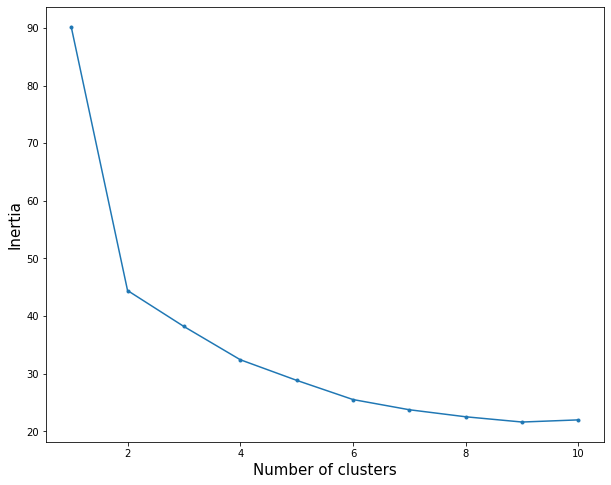

In [260]:
x = list(range(1, 11))
y = inertia

plt.figure(figsize=(10,8));
plt.plot(x, y, marker='.');
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('Inertia', fontsize=15);

In [354]:
#проводим кластеризацию методом K-means
kmeans = KMeans(n_clusters=9, random_state=17)
kmeans.fit(train_sc);

In [355]:
simple_df = train_sc
simple_df['kmeans'] = kmeans.labels_
means = simple_df.groupby(['kmeans']).mean()

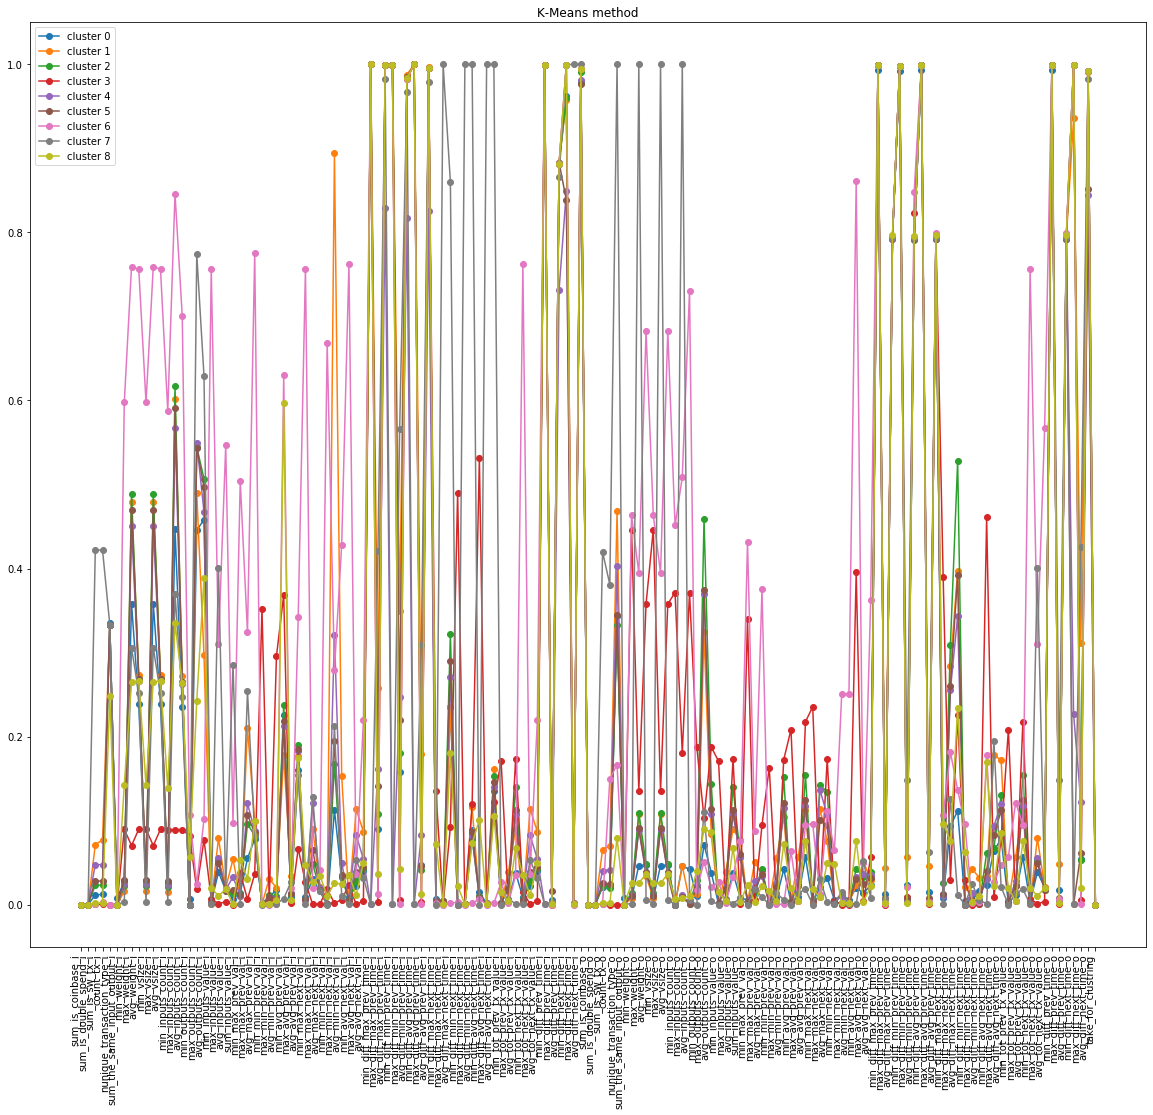

In [356]:
plt.figure(figsize=(20,17)) #формируем область для построения графиков под каждый из методов
for n in range(means.shape[0]): #для каждого кластера из данного метода
    plt.plot(feats, means.iloc[n, :].values, marker='o', label='cluster {}'.format(n))
    
plt.legend(loc = 'upper left') #делаем легенду графиа
plt.title('K-Means method') #название графика
plt.xticks(rotation=90, ha="right");

In [357]:
simple_df['kmeans'].value_counts()

2    255
0    187
8     63
5     62
4     53
1     47
3      7
6      4
7      1
Name: kmeans, dtype: int64

In [358]:
simple_df = simple_df.reset_index()

In [359]:
simple_df['is_suspicious'] = simple_df['add'].apply(lambda x: 1 if x in addr_list else 0)

In [361]:
simple_df[simple_df['is_suspicious']==1][['add','is_suspicious','kmeans']]

,add,is_suspicious,kmeans
1,1FQFFxz5TPJsRwkqHJa4ecd9gjQS2hYcbt,1,1
2,1HRPPH6gVPhL4tTbAM5CCcDFt2bXpR5vNm,1,3
5,1KqtK7K46kiFCV2XzAt43AYxNVwPuEccW6,1,6
291,3BPMdL5WVNYdBWVzfqRNkAMHiMkegporXn,1,6
452,3GdH7YrcFgQv4EANKDw66aZwruYCQ21LpL,1,6
490,3HpWfb94RXgbj59PnJijayj9t2ebFkfCQn,1,3


# PCA

In [288]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_sc)
pca_df = pd.DataFrame(data = principalComponents , columns = ['component_1', 'component_2'])

In [289]:
pca_df['add'] = train_sc.index

In [290]:
pca_df['is_suspicious'] = pca_df['add'].apply(lambda x: 1 if x in addr_list else 0)

In [291]:
pca_df[pca_df['is_suspicious']==1]

,component_1,component_2,add,is_suspicious
1,3.765897,0.309698,1FQFFxz5TPJsRwkqHJa4ecd9gjQS2hYcbt,1
2,0.793283,-0.561951,1HRPPH6gVPhL4tTbAM5CCcDFt2bXpR5vNm,1
5,-0.243139,-0.144317,1KqtK7K46kiFCV2XzAt43AYxNVwPuEccW6,1
291,-0.207555,-0.605360,3BPMdL5WVNYdBWVzfqRNkAMHiMkegporXn,1
452,-0.216577,-0.482913,3GdH7YrcFgQv4EANKDw66aZwruYCQ21LpL,1
490,0.794034,-0.565140,3HpWfb94RXgbj59PnJijayj9t2ebFkfCQn,1


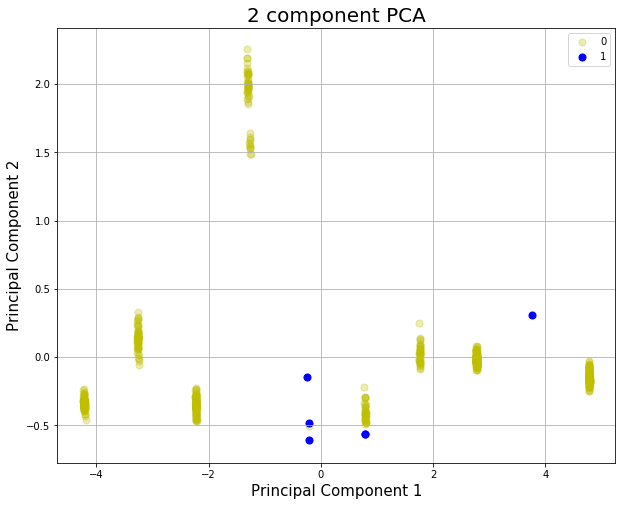

In [292]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['y', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['is_suspicious'] == target
    if target == 1: 
        alpha = 1
    else: 
        alpha = 0.3
        
    ax.scatter(pca_df.loc[indicesToKeep, 'component_1']
               , pca_df.loc[indicesToKeep, 'component_2']
               , c = color
               , s = 50
               , alpha = alpha)
ax.legend(targets)
ax.grid()
plt.show()

# K-Means after PCA

In [293]:
pca_df = pca_df.set_index('add')
pca_train = pca_df[['component_1', 'component_2']]

In [295]:
pca_inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state=1).fit(pca_train) 
    pca_inertia.append(np.sqrt(kmeans.inertia_))
print(pca_inertia)

[89.32517238479134, 41.827101516371826, 31.214894852145086, 19.963671414769763, 14.401354131005517, 9.366872052187002, 6.290145944734416, 3.6569236420743207, 2.8522258751101965, 2.2959722235338527]


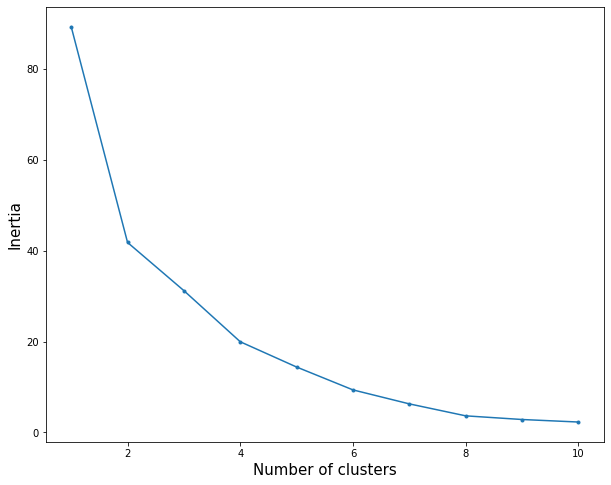

In [297]:
x = list(range(1, 11))
y = pca_inertia

plt.figure(figsize=(10,8));
plt.plot(x, y, marker='.');
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('Inertia', fontsize=15);

In [304]:
#проводим кластеризацию методом K-means
kmeans = KMeans(n_clusters=6, random_state=17)
kmeans.fit(pca_train);

pca_train['kmeans'] = kmeans.labels_
pca_means = pca_train.groupby(['kmeans']).mean()

In [305]:
pca_train['kmeans'].value_counts()

1    184
0    141
4    111
2    107
3     82
5     54
Name: kmeans, dtype: int64

## TSNE

In [323]:
train_sc = train_sc.drop('kmeans', axis=1)

In [325]:
tsne = TSNE(n_components=2, random_state=42)

In [326]:
X_2d = tsne.fit_transform(train_sc)
tsne_df = pd.DataFrame(data = X_2d , columns = ['component_1', 'component_2'])

In [327]:
tsne_df['add'] = train_sc.index

In [328]:
tsne_df['is_suspicious'] = tsne_df['add'].apply(lambda x: 1 if x in addr_list else 0)

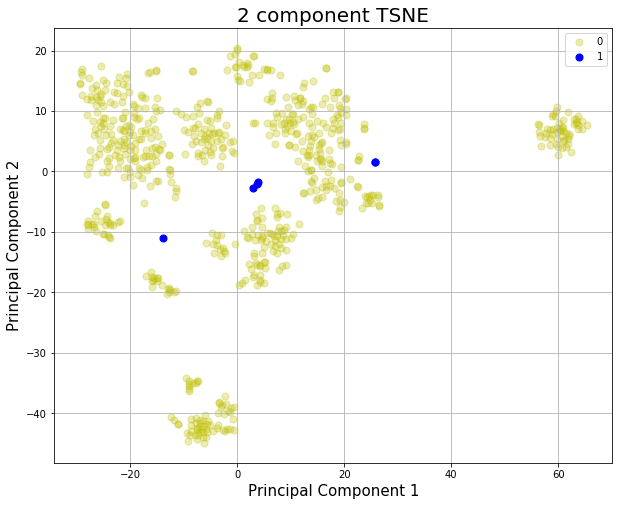

In [329]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component TSNE', fontsize = 20)
targets = [0, 1]
colors = ['y', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = tsne_df['is_suspicious'] == target
    if target == 1: 
        alpha = 1
    else: 
        alpha = 0.3
        
    ax.scatter(tsne_df.loc[indicesToKeep, 'component_1']
               , tsne_df.loc[indicesToKeep, 'component_2']
               , c = color
               , s = 50
               , alpha = alpha)
ax.legend(targets)
ax.grid()
plt.show()

## K_MEANS after TSNE

In [208]:
tsne_df = tsne_df.set_index('add')
tsne_train = tsne_df[['component_1', 'component_2']]

In [332]:
tsne_inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state=1).fit(tsne_train) 
    tsne_inertia.append(np.sqrt(kmeans.inertia_))
print(tsne_inertia)

[717.1299761004151, 540.0155540654188, 420.6658510044387, 286.896681808533, 235.66452934586601, 198.37340419066507, 172.12030884264234, 155.43339661299157, 143.30529665824946, 131.94717431417178]


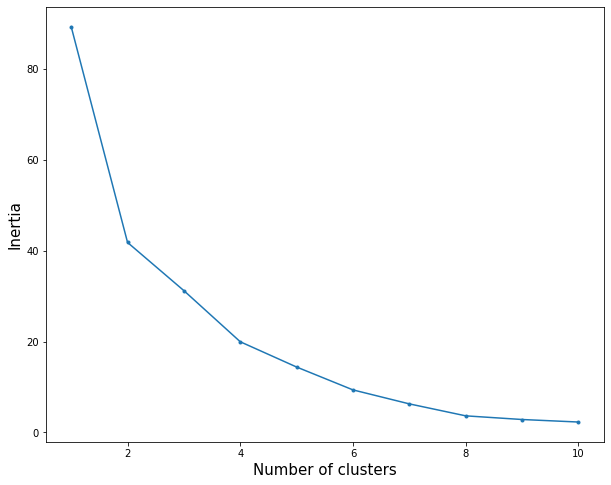

In [333]:
x = list(range(1, 11))
y = pca_inertia

plt.figure(figsize=(10,8));
plt.plot(x, y, marker='.');
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('Inertia', fontsize=15);

In [334]:
#проводим кластеризацию методом K-means
kmeans = KMeans(n_clusters=8, random_state=17)
kmeans.fit(tsne_train);

tsne_train['kmeans'] = kmeans.labels_
tsne_means = tsne_train.groupby(['kmeans']).mean()

In [335]:
tsne_train['kmeans'].value_counts()

6    153
0    110
5     90
7     85
4     73
2     65
3     54
1     49
Name: kmeans, dtype: int64

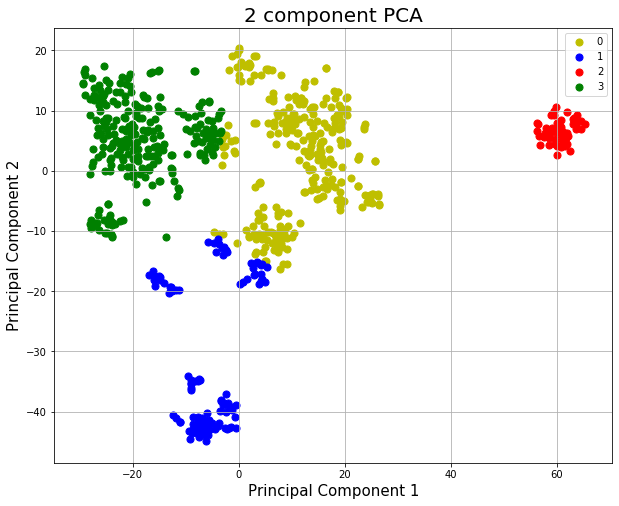

In [211]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2, 3]
colors = ['y', 'b', 'r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = tsne_train['kmeans'] == target
#     if target == 1: 
#         alpha = 1
#     else: 
#         alpha = 0.3
        
    ax.scatter(tsne_train.loc[indicesToKeep, 'component_1']
               , tsne_train.loc[indicesToKeep, 'component_2']
               , c = color
               , s = 50
               , alpha = alpha)
ax.legend(targets)
ax.grid()
plt.show()

In [154]:
tsne_train = tsne_train.reset_index()

In [155]:
tsne_train['is_suspicious'] = tsne_train['add'].apply(lambda x: 1 if x in addr_list else 0)

In [157]:
tsne_train[tsne_train['is_suspicious']==1]

,add,component_1,component_2,kmeans,is_suspicious
1,1FQFFxz5TPJsRwkqHJa4ecd9gjQS2hYcbt,-6.292921,-28.831192,1,1
2,1HRPPH6gVPhL4tTbAM5CCcDFt2bXpR5vNm,12.714198,-17.726261,1,1
3,1JqmxxswaEpvEcLJJLe8BTvmSHKYzY7LBn,-4.020684,-28.028902,1,1
5,1KqtK7K46kiFCV2XzAt43AYxNVwPuEccW6,7.530069,-13.482320,1,1
279,3AuShAzkBaAvL6Xc4y61Jfnf7AM7s3Wpmb,-4.435873,-22.883530,1,1
291,3BPMdL5WVNYdBWVzfqRNkAMHiMkegporXn,7.784631,-14.609373,1,1
452,3GdH7YrcFgQv4EANKDw66aZwruYCQ21LpL,7.738698,-14.423729,1,1
489,3HjJQWMhhJjAkPiZKywDYyhXDdWkSFLW9F,5.105273,-35.072655,1,1
490,3HpWfb94RXgbj59PnJijayj9t2ebFkfCQn,12.713997,-17.726236,1,1
602,3MycntSknbumLyRX56X8xbwxJ1zqHHq1VD,-4.644993,-28.604544,1,1


In [158]:
tsne_train['kmeans'].value_counts()

0    300
1    260
2     65
3     54
Name: kmeans, dtype: int64

 ## Decompose clst 1

In [169]:
add_clst_1 = tsne_train[tsne_train['kmeans']==1]['add'].tolist()

In [172]:
clst_1 = train_sc.reset_index()

In [173]:
clst_1['to_take'] = clst_1['add'].apply(lambda x: 1 if x in add_clst_1 else 0)
clst_1 = clst_1[clst_1['to_take']==1]

In [174]:
clst_1.shape

(260, 144)

In [165]:
clst_1 = tsne_train[tsne_train['kmeans']==1][['add', 'component_1', 'component_2']]

In [166]:
clst_1.shape

(260, 3)

In [167]:
clst_1['is_suspicious'] = clst_1['add'].apply(lambda x: 1 if x in addr_list else 0)

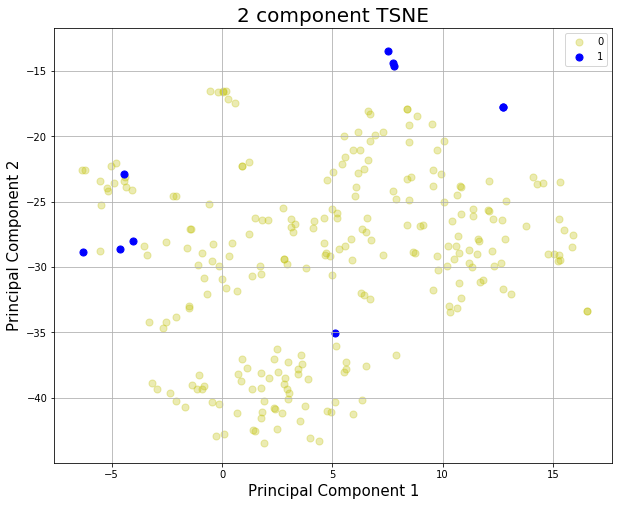

In [168]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component TSNE', fontsize = 20)
targets = [0, 1]
colors = ['y', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = clst_1['is_suspicious'] == target
    if target == 1: 
        alpha = 1
    else: 
        alpha = 0.3
        
    ax.scatter(clst_1.loc[indicesToKeep, 'component_1']
               , clst_1.loc[indicesToKeep, 'component_2']
               , c = color
               , s = 50
               , alpha = alpha)
ax.legend(targets)
ax.grid()
plt.show()

In [ ]:
#отдельно посчитать уникальность адресов относительно транзакций

## Graph

In [ ]:
result_df_dict = result_df.to_dict(orient='index')
not_attrs = ['input_add', 'output_add', 'txid', 'confirmations', 'time']
attrs = [x for x in cols if x not in not_attrs]

In [43]:
G = nx.DiGraph()

In [44]:
%%time
for i in result_df_dict:
    input_add = result_df_dict[i]['input_add']
    output_add = result_df_dict[i]['output_add']
        
    G.add_edge(input_add, output_add, 
               time=result_df_dict[i]['time'],
               is_coinbase=result_df_dict[i]['is_coinbase'],
               is_double_spend=result_df_dict[i]['is_double_spend'],
               weight=result_df_dict[i]['weight'],
               vsize=result_df_dict[i]['vsize'],
               inputs_count=result_df_dict[i]['inputs_count'],
               outputs_value=result_df_dict[i]['outputs_value'],
               max_prev_val=result_df_dict[i]['max_prev_val'],
               min_prev_val=result_df_dict[i]['min_prev_val'],
               avg_prev_val=result_df_dict[i]['avg_prev_val'],
               max_next_val=result_df_dict[i]['max_next_val'],
               min_next_val=result_df_dict[i]['min_next_val'],
               avg_next_val=result_df_dict[i]['avg_next_val'],
               diff_max_prev_time=result_df_dict[i]['diff_max_prev_time'],
               diff_min_prev_time=result_df_dict[i]['diff_min_prev_time'],
               diff_avg_prev_time=result_df_dict[i]['diff_avg_prev_time'],
               diff_max_next_time=result_df_dict[i]['diff_max_next_time'],
               diff_min_next_time=result_df_dict[i]['diff_min_next_time'],
               diff_avg_next_time=result_df_dict[i]['diff_avg_next_time'],
               is_suspicious=result_df_dict[i]['is_suspicious'],
               curr_value=result_df_dict[i]['curr_value'],
               tot_prev_tx_value=result_df_dict[i]['tot_prev_tx_value'],
               tot_next_tx_value=result_df_dict[i]['tot_next_tx_value'],
               diff_prev_time=result_df_dict[i]['diff_prev_time'],
               diff_next_time=result_df_dict[i]['diff_next_time'],
              )

CPU times: user 63.2 ms, sys: 4.47 ms, total: 67.7 ms
Wall time: 66.3 ms
